##**Lab 2**: *Exploring Image Data by Transforming Time-Series Data into Images*

*Team*

**Jaryd Domine**

**Sharon Yang**

---
###§1. Business Understanding

####Overview
Our objective is extrapolate price action from a partially complete day. In summary, this requires us to:
1. Generate daily price action images from various stocks
2. Use appropriate scaling when generating these images so that tickers with vastly different behavior can contribute similar information.
3. Use PCA/RPCA to generate "eigenprices," images from which to reconstruct price actions.
4. Create a new reconstruction function which can predict from a partial image without the unknown portion affection the calculation. (Hint: we use *partial components* to transform, and the full components to inverse transform. No idea if this is rigorous.)
5. Determine an adequate method of quantifying "accuracy" for this extrapolation. This tool will ultimately be a visual aid for day traders, so the scoring should reflect that.

We genereate our images from data gathered through the *yfinance* package https://pypi.org/project/yfinance/.

The tickers chosen were based on the list of *Big Cap Stocks* at https://www.tradingview.com/markets/stocks-usa/market-movers-large-cap/.

The data downloaded from yfinance is ordered in 6 columns: *Open*, *High*, *Low*, *Close*, *Adj Close* and *Volume*, and is indexed by *Datetime*. We picked 64 stock tickers over a span of 6 weeks (plus lead-in time for moving averages). We produce one image per ticker per day, using both 15-minute and 1-day interval data.



####Comparison to related methods

There is a considerably more rigorous and intelligent way to encoding timeseries to images described here: https://towardsdatascience.com/how-to-encode-time-series-into-images-for-financial-forecasting-using-convolutional-neural-networks-5683eb5c53d9

They (above) use Gramian Angular Fiends (GAFs), while we use the considerably more naive approach of just taking a "screenshot" of the price action, as a trader would see it.

We have made images out of each *day* to preserve the wild behavioral differences of each trading period (pre, regular, and after hours). Premarket (etc.) occupies the same space on each image.

We found no reference from which to base the following "partial image extrapolation" on. The result is a non-rigorous model that gives poor (visual) results, i.e. the extrapolation is murky and indecipherable.



####Prediction task

To specify the prediction task, we have the following:
>With inputs
1. Partially complete price action for a target ticker on a given day (15 minute interval)
2. Mean and std price for the past 5 days for the target ticker

>Predict
1. the remaining price action for the target ticker for the day, in the form of a visual extrapolation of the price action.

This model gives (ideally) a visual extrapolation of the price data, potentially as several *rivers* of possible flow.

####Utility of the model

Such a tool would be important mainly to day traders, those who buy and sell on a short time span. Equivalenty, this would be useful to those who care about intraday price action or those who already utilize 15-minute candle charts.

More generally, *any* algorithm which predicts the future of a ticker's price is on use to *any* trader. Even for long-term buy-and-hold strategies, this tool could (ideally) show where the high or low would fall for that day.

We would hope a model based on this extrapolation idea would manage to work out the same pattern recognition a human has, with regard to levels of support, signals for reversals, etc.


---
###§2.  Data Preparation

In [ ]:
!pip -q install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import missingno as msno
import matplotlib.pyplot as plt
from PIL import Image
from datetime import date, timedelta
from scipy.ndimage.filters import gaussian_filter
print(date.today())

2021-09-27


####Defining the time period and desired tickers

We first define time and date ranges for our data.
We chose a 15-min interval as our bin for 16 trading hours in a day from 4:00 to 20:00 (including extended hours), which would give us an image width of 64 pixels because 16 * 60 mins / 15 mins = 64. To repeat,
* A 15-minute time interval will produce an image width of 64 pixels, when including extended hours
* The vertical resolution is also a hyperparameter, which we set to 64 for the sake of squareness.

The 15-min interval data is available through *yfinance* as far back as 60 days. We chose to look back 6 weeks + 5 days for each ticker.
5 days are necessary at the start to calculate moving averages, as discussed later. This leaves 6 weeks worth of data, or around 30 business days for each ticker.

In [ ]:
# 42 days per ticker (6 weeks) + 5 days lead time for moving averages
DATA_NUM_DAYS  = 42 #days
MOV_AVG_PERIOD = 5 #days
start_date = date.today() - timedelta(1 + DATA_NUM_DAYS + MOV_AVG_PERIOD  + 1) #additional +1 day is for NaN interpolation
end_date   = date.today() - timedelta(1)

Our pool of tickers (which will be whittled down later) is chosen from the tickers with largest market cap:

In [ ]:
#Source: "large cap (big cap) tickers" https://www.tradingview.com/markets/stocks-usa/market-movers-large-cap/

#64 tickers with highest market cap
TICKERS_ALL = 'AAPL MSFT GOOGL GOOG AMZN FB TSLA NVDA TSM V JPM JNJ BABA WMT UNH ASML HD BAC MA PG PYPL DIS ADBE CRM NFLX CMCSA TM PFE ORCL XOM TMO CSCO NKE KO NVO DHR VZ LLY ABT INTC ACN PEP AVGO COST WFC CVX T ABBV AZN SE MS MRK TXN MCD NVS SHOP MDT MRNA SAP UPS TMUS LIN PTR PM'

#####Missing data

The *yfinance* library provides complete data for the '1d' (daily) interval.
However, there is no gurantee that intraday data (e.g. '15m' interval) will be complete.

Let's check for missing data:

[*********************100%***********************]  64 of 64 completed


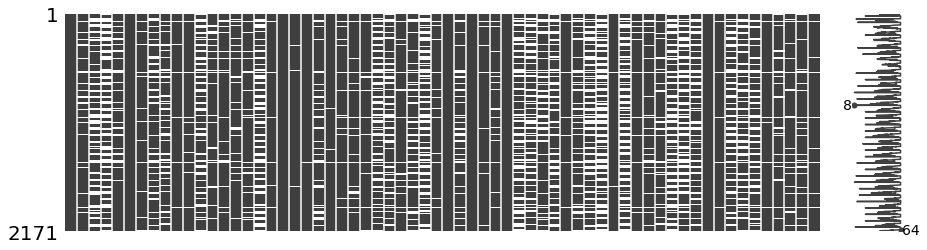

In [ ]:
# load 64 stock data together
ticker_data_15m = pd.DataFrame(yf.download(TICKERS_ALL, interval='15m', start=start_date, end=end_date, prepost=True))
msno.matrix(ticker_data_15m.Open, figsize=(15,4));

The amount of missing data varies widely between tickers. We decide to only keepThe following code was used to determine which tickers had at least 90% complete data:

In [ ]:
NAN_THRESH = 0.9
trim = ticker_data_15m.dropna(axis='columns', thresh=int(NAN_THRESH*len(ticker_data_15m)))
# assert list(trim.Open.columns) == list(trim.Close.columns) == list(trim.High.columns) == list(trim.Low.columns)

print('Tickers with at least',str(NAN_THRESH*100)+'% complete data:',len(trim.Open.columns))
print(' '.join(trim.Open.columns))

Tickers with at least 90.0% complete data: 35
AAPL ABBV ADBE AMZN ASML BABA BAC CRM CVX DIS FB GOOG GOOGL INTC JNJ JPM KO MA MRK MRNA MSFT NFLX NKE NVDA PFE PYPL SE SHOP TSLA TSM V VZ WFC WMT XOM


We will use this subset of tickers with mostly-complete data to generate the images:

In [ ]:
#subset of tickers with 90% complete data
# TICKERS = 'AAPL ABBV ADBE AMZN ASML BABA BAC COST CRM CSCO CVX DIS FB GOOG GOOGL INTC JNJ JPM KO MA MRK MRNA MSFT NFLX NKE NVDA PFE PYPL SE SHOP TSLA TSM V VZ WFC WMT XOM'
TICKERS = 'AAPL ABBV ADBE AMZN ASML BABA BAC CRM CVX DIS FB GOOG GOOGL INTC JNJ JPM KO MA MRK MRNA MSFT NFLX NKE NVDA PFE PYPL SE SHOP TSLA TSM V VZ WFC WMT XOM'
num_tickers = len(TICKERS.split())
num_tickers

35

####Data collection

We download the price action (Open, High, Low, Close) for the chosen tickers over the desired date range.

We maintain two dataframes with different time intervals:
1. *ticker_data_day*: One-day intervals
2. *ticker_data_15m*: 15-minute intervals

*yfinance* also gives us Adj Close and Volume columns, which we discard.

In [ ]:
ticker_data_day = pd.DataFrame(yf.download(TICKERS, interval='1d', start=start_date, end=end_date, prepost=True))
ticker_data_day.drop(columns=['Adj Close','Volume'],inplace=True)

ticker_data_15m = pd.DataFrame(yf.download(TICKERS, interval='15m', start=start_date, end=end_date, prepost=True))
ticker_data_15m.drop(columns=['Adj Close','Volume'],inplace=True)

[*********************100%***********************]  35 of 35 completed
[*********************100%***********************]  35 of 35 completed


#####Interpolation

Through the previous checks, we've kept only the tickers that have 90% complete 15-minute data.

We fill in any remaining NaN's by linear interpolation (the only option available for multi-indexed dataframes):

In [ ]:
ticker_data_15m.interpolate(limit_direction='both', inplace=True)

#####Computating additional quantities for scaling

Our prediction task is to extrapolate a day's partial price action using image techniques.

The importance of scaling will be made clear later, but for now, consider that whatever scaling method we use must not rely on the given day's price action, since it will be incomplete.

We have chosen to scale each image based on that ticker's recent mean and standard deviation of price.

To that end, we generate moving averages of both mean and std price for each ticker:

In [ ]:
for col in ['_mean','_std','_mean_ma','_std_ma']:
    for ticker in TICKERS.split():
        ticker_data_day[col,ticker] = np.nan

We divide the 15-minute dataframe into days, to align with the 1-day dataframe.

The number of images we will generate depends on the chosen time period, the number of tickers, and the length of the moving average window.

In [ ]:
#Group 15m data by day, and create a list of df's
daygrouper = ticker_data_15m.groupby(pd.Grouper(level='Datetime',dropna=True,freq='1d'))
dfdays     = [pd.DataFrame(y) for x,y in daygrouper if len(y)>0]

num_images = (len(dfdays)-MOV_AVG_PERIOD)*num_tickers

print("The data covers",len(dfdays),"trading days.")
print("The first",MOV_AVG_PERIOD,"days are used to calculate moving averages.")
print("("+str(len(dfdays)),"-",str(MOV_AVG_PERIOD)+") days x",num_tickers,"tickers =",num_images,"images to be generated.")

The data covers 34 trading days.
The first 5 days are used to calculate moving averages.
(34 - 5) days x 35 tickers = 1015 images to be generated.


With the following code, we calculate the mean and std price for each ticker on each day. We average the values from Open and Close for stability.

In [ ]:
for day in dfdays:
    date = str(day.index.date[0])

    #calculate mean and std for each of Open, Close, High, and Low
    _mean = day.mean()
    _std  = day.std()
    
    #average the results of Open and Close to get a more stable result
    _mean = list(0.5 * (_mean.Open+_mean.Close))
    _std  = list(0.5 * (_std.Open+_std.Close))

    ticker_data_day.loc[date,'_mean'] = _mean
    ticker_data_day.loc[date,'_std']  = _std

# A cross section of the computed data for AAPL:
# ticker_data_day.xs('AAPL',axis=1,level=1).head()

The moving averages mean_ma and std_ma are calculated by rolling window, which is then shifted so that the current day is not factored in. As mentioned, we want the scaling to be based on data previously available.

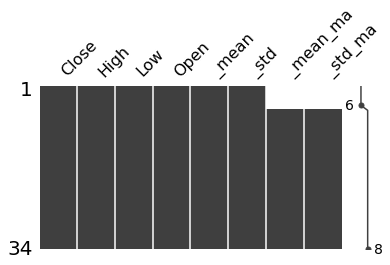

In [ ]:
#Using a rolling window with shift to produce the moving average
ticker_data_day['_mean_ma'] = ticker_data_day._mean.rolling(MOV_AVG_PERIOD).mean().shift()
ticker_data_day['_std_ma']  = ticker_data_day._std.rolling(MOV_AVG_PERIOD).mean().shift()

#visualize the missing data at the beginning of the rolling mean columns
msno.matrix(ticker_data_day.xs('AAPL',axis=1,level=1), figsize=(6,3))

The moving average computation leaves some NaNs in the first 5 rows. We discard these rows and ensure the various data stuctures are of the right size.

In [ ]:
#Remove the initial NaNs. ensure this does not run twice
assert ticker_data_day.isnull().values.any()
ticker_data_day = ticker_data_day[MOV_AVG_PERIOD:]
dfdays = dfdays[MOV_AVG_PERIOD:]

In [ ]:
assert len(dfdays) == len(ticker_data_day)
assert num_images  == len(dfdays)*num_tickers
print(len(dfdays))

29


---

#####Why scale?

Horizontal scaling was obvious: use a time interval that gives a width between 20 and 100 pixels. 

Vertical scaling was considerably more time-consuming to work out. Our first question was

>How do we scale price-to-pixels for each day?

We first tried a min-max scaling, but the presence of outliers would cause the rest of the day's price action to be squashed flat.

To handle outliers, we tried a percentile clip. Any values below the 1st percentile or above the 99th percentile were 'clipped' to fit in that range.

But, since our objective was to predict from a *partial* image, we then noticed a glaring issue:

>How do we scale a *partial* day, for which the price range is clearly not known?

The methods we had tried all involved the low and high of a given day. But if the day is just beginning, we can only guess what these bounds will be.

We want to meaningfully incorporate the price action of many different stocks into our model. How can we do that?

Consider instead the following:
 * Each ticker has its own mean and variance. Some stocks may cost hundreds of dollars but fluctuate little, while other stocks may cost pennies but fluctuate many hundreds of percents (e.g. "penny stocks").
 * Technical analysis (e.g. support and resistance considerations) obeys many of the same principles regardless of mean and variance.
 * The mean and variance for the ticker we're trying to predict *can be tracked beforehand*. We can keep a **daily moving average of price and variance** for each ticker, to give us a scaling for the next day.

With this implementation, our model would require 2 inputs:
 * Partial price action for the day
 * Mean and variance of price for past 5 trading days, to determine image scaling


To illustrate the need for scaling, we plot the unscaled and scaled price actions:

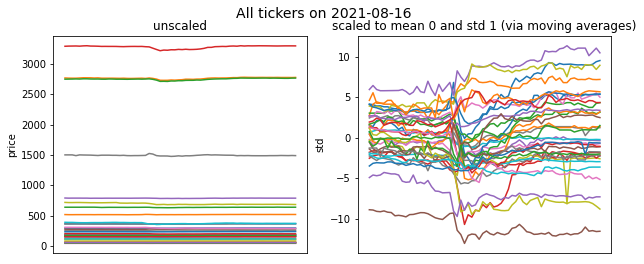

In [ ]:
delta = timedelta(days=1)
date_loop = start_date
ticker_names = locals()
while date_loop <= end_date:
    for idx in range(len(TICKERS.split())):
        ticker_names[TICKERS.split()[idx]+ '_15m'][date_loop]# Plot rescaled price actions for the first day
fig,ax = plt.subplots(1,2,figsize=(10,4))
date0 = str(dfdays[0].index.date[0])

fig.suptitle('All tickers on '+str(date0),fontsize=14)
ax[0].set_title('unscaled')
ax[0].set_ylabel('price')
ax[0].xaxis.set_visible(False)
ax[1].set_title('scaled to mean 0 and std 1 (via moving averages)')
ax[1].set_ylabel('std')
# ax[1].set_ylim(-4,4)
ax[1].xaxis.set_visible(False)

for ticker in TICKERS.split():
    _mean_ma = ticker_data_day.loc[date0]['_mean_ma',ticker]
    _std_ma  = ticker_data_day.loc[date0]['_std_ma',ticker]
    # print(_mean_ma,_std_ma)
    ax[0].plot(ticker_data_15m.loc[date0]['Open',ticker])
    ax[1].plot((ticker_data_15m.loc[date0]['Open',ticker]-_mean_ma)/_std_ma)
    

Without intelligent scaling, the images we generate (e.g. from the left plot) would be worthless.

####Generating the images

We set the image height to 64 to match the width.

For the vertical scaling, we transform the price action the zero mean and std 1, based on the moving averages of mean and std.

We choose how many standard deviations the image should cover vertically. Since we use a rolling mean, the conventional wisdom about 3 stds encapsulating most of the data does not hold. We instead take 15 in either direction, based on the plot above.

The resulting *price_to_pixel* function will map a price to the pixel range 0-64.

In [ ]:
IMG_HEIGHT = 64
NUM_STDS = 15 #number of standard deviations shown above/below mean
def price_to_pixel(mean,std,price): #minmax scaler centered on Open
    radius = std * NUM_STDS
    pixpos = (price-mean+radius) * IMG_HEIGHT/(2*radius)
    return max(min(int(pixpos),IMG_HEIGHT),0)

price_to_pixel(700,20,710)

33

#####Single image

To get a sense for how this works for a single ticker on a single day, we use the following code to plot 'AAPL' on the 10th trading day of the data:

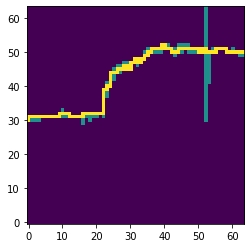

In [ ]:
dayidx = 10
ticker = 'AAPL'

day = dfdays[dayidx].xs(ticker,axis='columns',level=1).reset_index(drop=True)
date = str(dfdays[dayidx].index.date[0])

_mean_ma = ticker_data_day.loc[date]['_mean_ma',ticker]
_std_ma  = ticker_data_day.loc[date]['_std_ma',ticker]

M = np.zeros((len(day),IMG_HEIGHT))
for idx,row in day.iterrows():

    lo = price_to_pixel(_mean_ma,_std_ma,row.Low)
    hi = price_to_pixel(_mean_ma,_std_ma,row.High)
    M[lo:hi+1,idx] = 0.5

    op = price_to_pixel(_mean_ma,_std_ma,row.Open)
    cl = price_to_pixel(_mean_ma,_std_ma,row.Close)
    M[min(op,cl):max(op,cl)+1,idx] = 1
    
plt.imshow(M,origin='Lower') #gaussian_filter(M,sigma=1)

We then apply a filter to reduce noise. Removing the sharp edges will hopefully aid PCA in determining meaningful components.

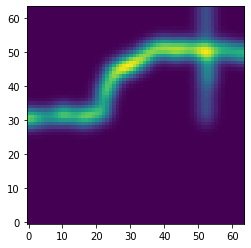

In [ ]:
plt.imshow(gaussian_filter(M,sigma=2),origin='lower')

#####All images

In [ ]:
IMG_HEIGHT = 64
BLUR_RAD = 2
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/PML Lab 2 Images Blur/'

namelist = ''

for i,day in enumerate(dfdays):
    date = str(day.index.date[0])

    for ticker in TICKERS.split():
        #initialize the image to zero (array)
        M = np.zeros((len(day),IMG_HEIGHT))
    
        #get the scaling factors to apply to the current ticker/day
        _mean_ma = ticker_data_day.loc[date]['_mean_ma',ticker]
        _std_ma  = ticker_data_day.loc[date]['_std_ma',ticker]
    
        #write to each column of pixels in the image
        for j,(idx,row) in enumerate(day.iterrows()):
            #fill a vertical line with the value 0.5 between the Low and High
            lo = price_to_pixel(_mean_ma,_std_ma,row.Low[ticker])
            hi = price_to_pixel(_mean_ma,_std_ma,row.High[ticker])
            M[lo:hi+1,j] = 0.5

            #fill a vertical line with the value 1.0 between the Open and Close
            op = price_to_pixel(_mean_ma,_std_ma,row.Open[ticker])
            cl = price_to_pixel(_mean_ma,_std_ma,row.Close[ticker])
            M[min(op,cl):max(op,cl)+1,j] = 1
        
        #blur the image slightly to make the overall shape more apparent
        M = gaussian_filter(M,sigma=BLUR_RAD)
        
        #Save the ticker/day matrix as an image and store its name
        im   = Image.fromarray(np.uint8(M*255))
        name = date+' '+ticker+'.png'
        im.save(SAVE_DIR+name)
        namelist += name+';'

#The names are stored in a ';'-delimited text file
namelist = namelist[:-1]
with open(SAVE_DIR+'namelist.txt','w') as f:
    f.write(namelist)

---
###§3. Data Reduction
[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

[1 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).

[2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

####Data loading

Import the images we've created.

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/PML Lab 2 Images Blur/'

#Populate a namelist to access images from the Google Drive folder.
namelist = ''
with open(DATA_PATH+'namelist.txt') as f:
    namelist = f.readlines()[0].split(';')

#Load the images as matrices
images = []
for name in namelist:
    print(name)
    im = Image.open(DATA_PATH+name)
    images.append(np.nan_to_num(np.asarray(im)))

h,w = images[0].shape

Define a convenience plotting function to show the first 100 of a given set of images:

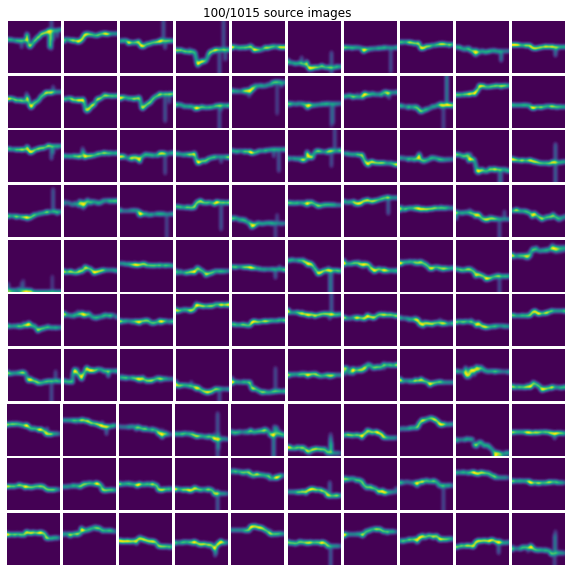

In [ ]:
def plot_100_images(images,title):
    fig,ax = plt.subplots(10,10,figsize=(10,10))
    plt.subplots_adjust(hspace=0.05,wspace=0.05)
    for i,a in enumerate(ax.flatten()):
        if i>=len(images): break
        a.imshow(images[i],origin='lower')
        a.axis('off')
    fig.suptitle(title,y=0.9)

plot_100_images(images,'100/'+str(len(images))+' source images')

Create the data array, using DataFrame as an intermediary to remove any NaNs:

In [ ]:
X = pd.DataFrame([list(image.flatten()) for image in images]).fillna(0).astype(np.uint8)
X = np.asarray(X)

Form a train-test split, using the typical 80-20 ratio

In [ ]:
Xtrain,Xtest = train_test_split(X,test_size=0.2,random_state=0)

In [ ]:
len(Xtrain)

812

####PCA v. RPCA

We first need to determine an ideal number of components for PCA/RPCA. We take 200 as an upper limit and fir both models:

In [ ]:
NUM_COMPONENTS = 200
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(Xtrain.copy())
rpca = PCA(n_components=NUM_COMPONENTS, svd_solver='randomized')
rpca.fit(Xtrain.copy())

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

#####Scree plot comparison (including non-blur)

The following code answers two questions:
>
1. What was the point of adding blur?
2. are PCA and RPCA any different in terms of EV (explained variance)?

Text(0.5, 1.0, 'scree, no blur')

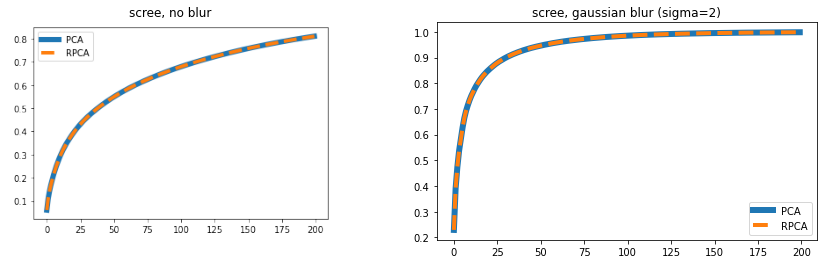

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

#plot the blur scree
pca_cum_ev = np.cumsum(pca.explained_variance_ratio_)
rpca_cum_ev = np.cumsum(rpca.explained_variance_ratio_)
ax[1].plot(range(NUM_COMPONENTS),pca_cum_ev,linewidth=6)
ax[1].plot(range(NUM_COMPONENTS),rpca_cum_ev,linestyle='--',linewidth=4)
ax[1].legend(['PCA','RPCA'])
ax[1].set_title('scree, gaussian blur (sigma=2)')

#plot the noblur scree
im = Image.open('pca_scree_noblur.png')
ax[0].imshow(im)
ax[0].axis('off')
ax[0].set_title('scree, no blur')

>**Adding blur made a massive difference to EV.**
Without blur, it took 200 components to get to ~80% EV. With blur, we can achieve ~90% EV with only 25 components.

>**PCA and RPCA have essentially the same scree plot** (diff is shown below), thus the following analysis applies to both.

* With 25 components, the EV is ~90%.
* Doubling to 50 components gives an EV of ~95%. The "knee" of the scree plot is around 30 components, so we get a bit further and keep **50**.

If we directly compare EV between randomized and full PCA, we get the following:

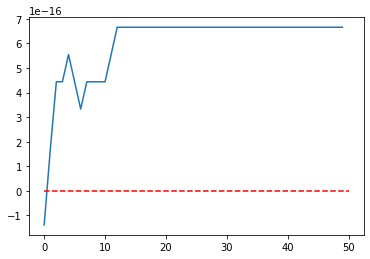

In [ ]:
plt.plot(range(50),pca_cum_ev[:50]-rpca_cum_ev[:50])
plt.plot([0,50],[0,0],'r--')

This is a plot of *pca_cum_ev - rpca_cum_ev*. The difference in EV is *extremely negligible*.

#####Eigenprices comparison

We refer to the pca components as "eigenprices." We plot all 100 eigenprices for pca and rpca below:

In [ ]:
eigenprices  = pca.components_.reshape((NUM_COMPONENTS, h, w))
reigenprices = rpca.components_.reshape((NUM_COMPONENTS, h, w))

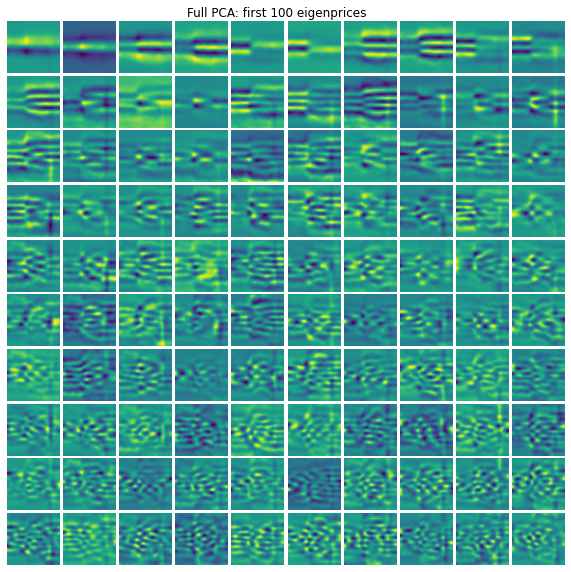

In [ ]:
plot_100_images(eigenprices,'Full PCA: first 100 eigenprices')

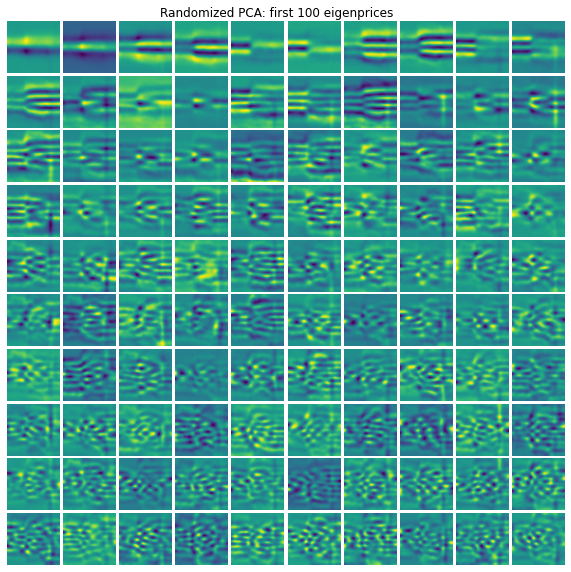

In [ ]:
plot_100_images(reigenprices,'Randomized PCA: first 100 eigenprices')

As shown by the scree plot, the EV of PCA and RPCA is negligible. The differences in the eigenprices (shown below) quickly devolves to noise after the first 7 components:

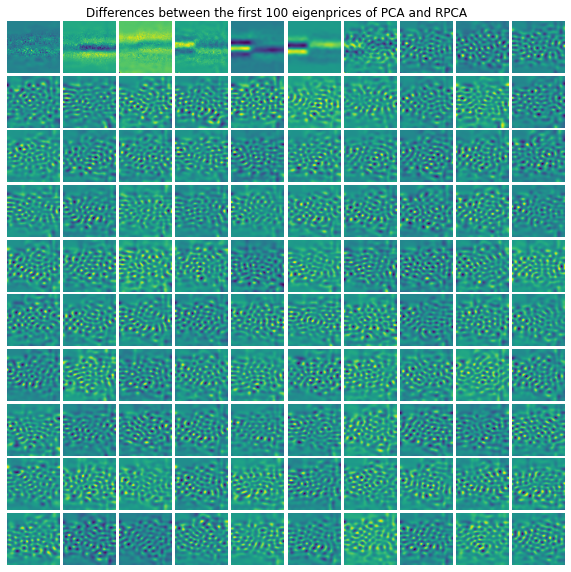

In [ ]:
plot_100_images(eigenprices-reigenprices,'Differences between the first 100 eigenprices of PCA and RPCA')

#####Image reconstruction

As mentioned, we will keep 50 components which is sufficient for an EV of 95%:

In [ ]:
NUM_COMPONENTS = 50
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(Xtrain.copy())
rpca = PCA(n_components=NUM_COMPONENTS, svd_solver='randomized')
rpca.fit(Xtrain.copy())

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

Here comes a doozy of a function.

The reconstruction function used in class has two main steps,
1. *transform* to get low dim representation
2. *inverse transform* to get a reconstructed image

Here's the problem:
>If we use the normal reconstruction process on partially complete data, PCA will attempt to fit the incomplete part with zeros.

i.e., if we only have the first half of the day available, PCA will try to fit the known price action on the left and try to *fit to all zeroes* on the right.

We thus make the *reconstruct_from_partial* function **agnostic** to the unknown data by cutting down the PCA components as well.

To summarize, we:
1. Transform using cut-off components
2. Inverse transform using whole components

I have no mathematical proof or sources to back up why this might work, it's just handwaving at this point.


In [ ]:
def reconstruct_from_partial(pca,row,n_known_columns,show=True,figtitle=''):
    #Code adapted from PCA source code:
    #https://github.com/scikit-learn/scikit-learn/blob/9b033758e/sklearn/decomposition/_base.py#L97

    #cut off the given image beyond the first n columns
    row_cut = row.copy().reshape(h,w)
    row_cut[:,n_known_columns:] = 0
    X = row_cut.reshape(1,-1)

    #processing from original tranform method
    # X = pca._validate_data(X, dtype=[np.float64, np.float32], reset=False)
    if pca.mean_ is not None:
        X = X - pca.mean_

    #cut off the components beyond the first n columns
    components_cut = pca.components_.copy().reshape(NUM_COMPONENTS,h,w)
    components_cut[:,:,n_known_columns:] = 0
    components_cut = components_cut.reshape(NUM_COMPONENTS,-1)

    #transform
    low_rep = np.dot(X, components_cut.T)

    #inverse tranform
    rec_row = np.dot(low_rep, pca.components_) + pca.mean_

    #optional plotting
    if show:
        fig,ax = plt.subplots(1,3,figsize=(15,5))
        fig.suptitle(figtitle,y=0.95,fontsize=14)
        
        ax[0].imshow(row_cut.reshape(h,w),origin='lower')
        ax[0].plot([n_known_columns-0.5]*2,[0,h-1],'r--')
        ax[0].set_title('partial ('+str(n_known_columns)+' column) image')

        ax[1].imshow(rec_row.reshape(h,w),origin='lower')
        ax[1].plot([n_known_columns-0.5]*2,[0,h-1],'r--')
        ax[1].set_title('reconstruction from partial image')
        
        ax[2].imshow(row.reshape(h,w),origin='lower')
        ax[2].plot([n_known_columns-0.5]*2,[0,h-1],'r--')
        ax[2].set_title('actual price action')

    return low_rep, rec_row

The following is a cherry-picked example of this *somewhat* working as intended. We want the reconstruction to highlight a *river of possibility* of where it might go. The intuition is that if the components are similar to the known part of the image, they might be similar to the unknown part as well.

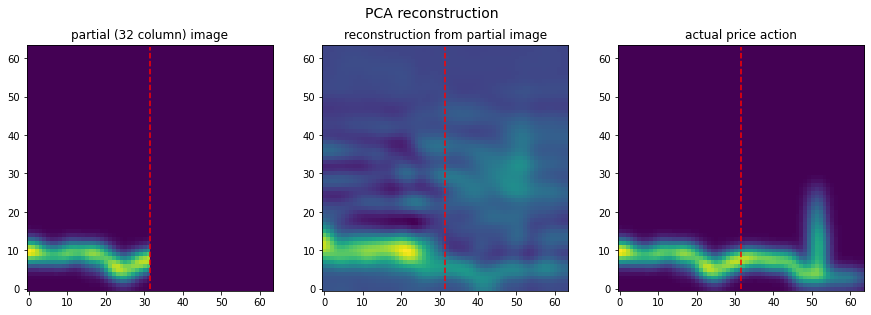

In [ ]:
KNOWN_COLS = 32
row = Xtest[1]

_,pca_recon =reconstruct_from_partial(pca,row,KNOWN_COLS,figtitle='PCA reconstruction');

As we may expect, the RPCA reconstruction is not noticably different:

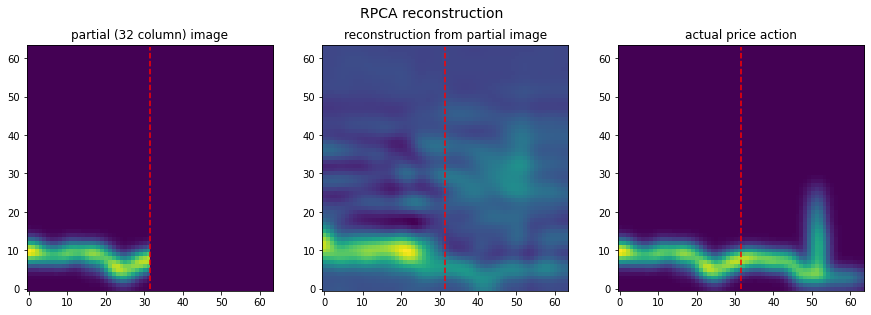

In [ ]:
_,rpca_recon = reconstruct_from_partial(rpca,row,KNOWN_COLS,figtitle='RPCA reconstruction');

We plot the difference between the PCA and RPCA reconstructions and notice no relevant difference in terms of the "predicted path."

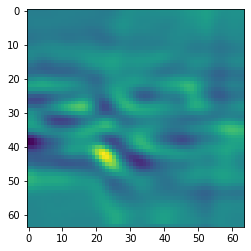

In [ ]:
plt.imshow((pca_recon-rpca_recon).reshape(h,w))

####Nearest neighbors reconstruction

We make the NN algorithm agnostic to unknown values by cutting train and test:

In [ ]:
KNOWN_COLS = 20

ntrain = Xtrain.shape[0]
Xtrain_cut = Xtrain.copy().reshape(ntrain,h,w)
Xtrain_cut[:,:,KNOWN_COLS:] = 0
Xtrain_cut = Xtrain_cut.reshape(ntrain,-1)

ntest = Xtest.shape[0]
Xtest_cut = Xtest.copy().reshape(ntest,h,w)
Xtest_cut[:,:,KNOWN_COLS:] = 0
Xtest_cut = Xtest_cut.reshape(ntest,-1)

We calculate NNs using the cut train/test images

In [ ]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBORS = 2

nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='ball_tree').fit(Xtrain_cut)
_, NN_table = nbrs.kneighbors(Xtest_cut)

We then test the reconstruction capability:

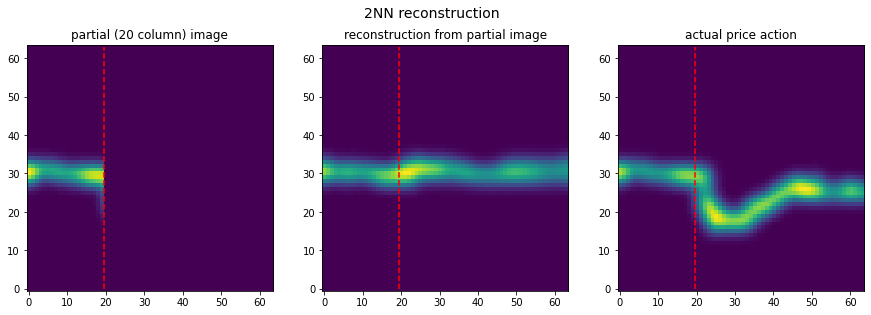

In [ ]:
from ipywidgets import widgets, fixed

def compare_reconstruction(i,N):
    NNs = NN_table[i]

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle(str(N)+'NN reconstruction',y=0.95,fontsize=14)

    ax[0].imshow(Xtest_cut[i].reshape(h,w),origin='lower')
    ax[0].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[0].set_title('partial ('+str(KNOWN_COLS)+' column) image')

    ax[1].imshow(Xtrain[NNs].sum(axis=0).reshape(h,w),origin='lower')
    ax[1].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[1].set_title('reconstruction from partial image')

    ax[2].imshow(Xtest[i].reshape(h,w),origin='lower')
    ax[2].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[2].set_title('actual price action')

compare_reconstruction(i=123,N=N_NEIGHBORS)
# widgets.interact(compare_reconstruction,i=fixed(123),N=fixed(N_NEIGHBORS),__manual=True) #i=(0,ntest-1,1),

We're taking the pairwise sum of 2 nearest neighbors, which visually appears as there being two "routes" the extrapolation could take. This is not visible here, as both NN's lay on top of eachother.

This particular test image will be relevant when compared to DAISY.

Right off the bat, this is much more effective than PCA was at extrapolating data. There is the issue of **most price action goes straight across**, but in the shown instance, one of the neighbors suggests a "step-up' in price, which agrees with the actual price action.

####DAISY feature extraction plus NN reconstruction

This time, we first extract features using daisy and then repeat the process of finding the nearest neighbor price actions.

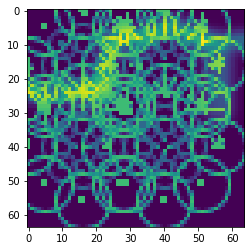

In [ ]:
from skimage.feature import daisy

img = Xtrain[45].reshape(h,w)
features, overlay = daisy(img, step=24, radius=16, rings=2, histograms=8, orientations=8, visualize=True)
plt.imshow(overlay[:,:,2]+img/255)


The plot above shows the arrangement of the daisy grid for the given parameters. With these chosen daisy parameters, each image is reduced to 544 features (down from 64*64 = 4096)

In [ ]:
print(features.shape)
print(np.product(features.shape))

(2, 2, 136)
544


Again, we make the algorithm agnostic to unknown data by cutting off unknown values:

In [ ]:
KNOWN_COLS = 25

ntrain = Xtrain.shape[0]
Xtrain_cut = Xtrain.copy().reshape(ntrain,h,w)
Xtrain_cut[:,:,KNOWN_COLS:] = 0
Xtrain_cut = Xtrain_cut.reshape(ntrain,-1)

ntest = Xtest.shape[0]
Xtest_cut = Xtest.copy().reshape(ntest,h,w)
Xtest_cut[:,:,KNOWN_COLS:] = 0
Xtest_cut = Xtest_cut.reshape(ntest,-1)

We generate a new set of arrays for the daisy features:

In [ ]:
def apply_daisy(row):
    features = daisy(row.reshape(h,w), step=24, radius=16, rings=2, histograms=8, orientations=4, visualize=False)
    return features.reshape((-1))

Xtrain_daisy_features = np.apply_along_axis(apply_daisy, 1, Xtrain_cut)
Xtest_daisy_features  = np.apply_along_axis(apply_daisy, 1, Xtest_cut)
print(Xtrain_daisy_features.shape)

(812, 272)


Following the exact process as before, we compare prediction to reality:

In [ ]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBORS = 2

nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='ball_tree').fit(Xtrain_daisy_features)
_, NN_table = nbrs.kneighbors(Xtest_daisy_features)

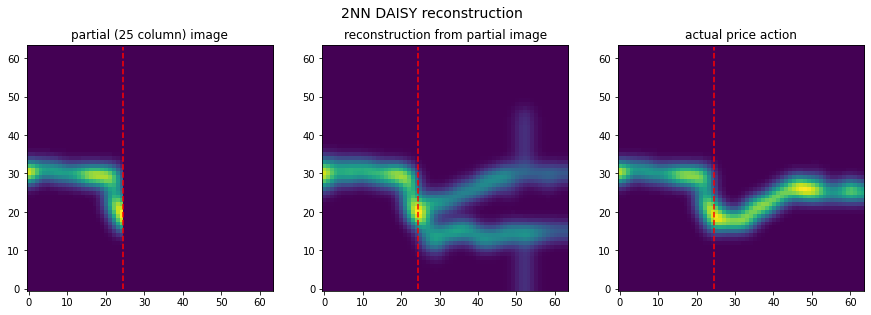

In [ ]:
from ipywidgets import widgets, fixed

def compare_reconstruction_daisy(i,N):
    NNs = NN_table[i]

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle(str(N)+'NN DAISY reconstruction',y=0.95,fontsize=14)

    ax[0].imshow(Xtest_cut[i].reshape(h,w),origin='lower')
    ax[0].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[0].set_title('partial ('+str(KNOWN_COLS)+' column) image')

    ax[1].imshow(Xtrain[NNs].sum(axis=0).reshape(h,w),origin='lower')
    ax[1].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[1].set_title('reconstruction from partial image')

    ax[2].imshow(Xtest[i].reshape(h,w),origin='lower')
    ax[2].plot([KNOWN_COLS-0.5]*2,[0,h-1],'r--')
    ax[2].set_title('actual price action')

compare_reconstruction_daisy(i=123,N=N_NEIGHBORS)
# widgets.interact(compare_reconstruction,i=fixed(123),N=fixed(N_NEIGHBORS),__manual=True) #i=(0,ntest-1,1)

For this particular test image, DAISY features provided a much more interesting pair of extrapolations. While plain NN just gave straight, horizontal trajectories, the DAISY features gave two very not-straight trajectories. One matches the actual price action quite well.

---
###§4. Exceptional Work
>Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive.
---

The idea of patch-matching sections of price-action to one another has obvious implications. If the last hour of price action matches closely in form to some past portion of the price action, we simply look at *what historically happened next*.

Traders do this on their own, as looking at historical price action is a great way to improve your intuition.

Key-point matching with daisy could be used to:
* perform matching on a single continuous stream of data instead of many individual day images (patterns spanning multiple days would be highly informative)
* rapidly pull up relevant historical price action for a trader to consider in real time
* rapidly compare historical price action to current price action on multiple timescales simultaneously to inform a prediction


####Finding a historical match

Consider a price action image covering a 2 week span:

Text(0.5, 1.0, 'scene')

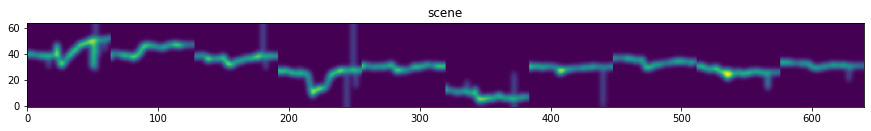

In [ ]:
scene = np.concatenate(images[:10],axis=1)

fig,ax = plt.subplots(figsize=(15,4))
ax.imshow(scene,origin='lower')
ax.set_title('scene')

We wish to find an instance of the following patch within it:

Text(0.5, 1.0, 'patch')

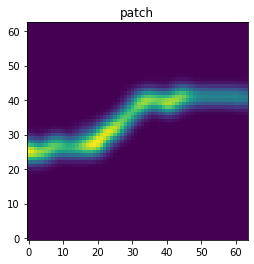

In [ ]:
patch = images[125]

fig,ax = plt.subplots()
ax.imshow(patch,origin='lower')
ax.set_title('patch')

Adapting the code from the class notebook, we search for a descriptor match among all daisies covering each image:

In [ ]:
#Adapted from https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb

from skimage.feature import daisy, match_descriptors, plot_matches

def apply_daisy(img):
    feat = daisy(img, step=24, radius=16, rings=2, histograms=8, orientations=4, visualize=False)
    s = feat.shape
    return feat.reshape((s[0]*s[1],s[2]))

d1 = apply_daisy(patch)
d2 = apply_daisy(scene)

print(d1.shape, d2.shape)

matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
print(f"Number of matches: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

(4, 68) (52, 68)
Number of matches: 1, Percentage:25.00%


A total of 4 daisies fit on the patch, and 52 fit on the scene. We manage to find one successful match.

We could not find a method to reverse engineer the location of these descriptors in order to match locations between images. While it is simple to find the centers of each ring (4 shown below) using trig, the order in which the rings correspond to rows is unknown.

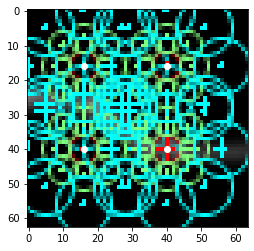

In [ ]:
def apply_daisy(img):
    feat,vis = daisy(img, step=24, radius=16, rings=2, histograms=8, orientations=4, visualize=True)
    plt.imshow(vis)
    s = feat.shape
    return feat.reshape((s[0]*s[1],s[2]))

apply_daisy(patch);
plt.scatter([16,16+24,16,16+24],[16,16,16+24,16+24],color='white')

In [ ]:
matches

array([[ 2, 49]])

#Scrap

In [ ]:
# load each stock data separately
# ticker_names = locals()
# for idx in range(len(TICKERS_ALL.split())):
# ticker_names[TICKERS_ALL.split()[idx]+ '_15m'] = pd.DataFrame(yf.download(TICKERS_ALL.split()[idx], interval='15m', start=start_date, end=end_date, prepost=True))
# load each stock data separately
# ticker_names = locals()
# for idx in range(len(TICKERS.split())):
#     ticker_names[TICKERS_ALL.split()[idx]+ '_15m'] = pd.DataFrame(yf.download(TICKERS_ALL.split()[idx], interval='15m', start=start_date, end=end_date, prepost=True))
#     ticker_names[TICKERS_ALL.split()[idx]+ '_15m'].drop(columns=['Adj Close','Volume'],inplace=True)
#     ticker_names[TICKERS_ALL.split()[idx]+ '_1d'] = pd.DataFrame(yf.download(TICKERS_ALL.split()[idx], interval='1d', start=start_date, end=end_date, prepost=True))
#     ticker_names[TICKERS_ALL.split()[idx]+ '_1d'].drop(columns=['Adj Close','Volume'],inplace=True)

#Code taken from class notebook "Dimension Reduction and Images"
# def reconstruct_full(pca,row):
#     X = row.copy().reshape(1,-1)
#     low_rep = pca.transform(X)
#     rec_row = pca.inverse_transform(low_rep)
#     return low_rep, rec_row

# def gen_partial_row(row,n_known_columns):
#     row_cut = row.reshape(h,w)
#     row_cut[:,n_known_columns:] = 0
#     return row_cut.flatten()

# def reconstruct_partial(transformer,row,n_known_colums):
#     row_cut = row.reshape(h,w)
#     row_cut[:,n_known_colums:] = 0
#     row_cut.reshape(1,-1)
#     low_rep = transformer.transform(row_cut)
#     rec_row = transformer.inverse_transform(low_rep)
#     return low_rep, rec_row

# IMGS_PER_ROW = 50

# fig,ax = plt.subplots(num_images//IMGS_PER_ROW + 1,IMGS_PER_ROW,figsize=(15,10))
# plt.subplots_adjust(hspace=0.05,wspace=0.05)

# a = ax[i//7][i%7]
# a.axis('off')

# a.imshow(M,origin='Lower') #gaussian_filter(M,sigma=1)

# delta = timedelta(days=1)
# date_loop = start_date
# ticker_names = locals()
# while date_loop <= end_date:
#     for idx in range(len(TICKERS.split())):
#         ticker_names[TICKERS.split()[idx]+ '_15m'][date_loop]

# data = pd.DataFrame(columns=['Datetime','Symbol','Mean','Std','Mean_ema5-1','Std_ema5-1'])
# data.Datetime = pd.date_range(start_date,end_date,closed='left')
# data.Symbol[:10] = 'TSLA'

# data[data.Symbol=='TSLA'] = 1


# print('ema5-1: The exponential moving average of the 5 days *before* the current date')
# data

# IMGHEIGHT = 64
# def price_to_pixel_minmax(df,price): #minmax scaler centered on Open
#     dayopen = df.Open[0]
#     daymax  = df.High.max()
#     daymin  = df.Low.min()
#     radius  = max(daymax-dayopen,dayopen-daymin)
#     pixpos  = (price-(dayopen-radius)) * IMGHEIGHT/(2*radius)
#     return int(pixpos)